In [55]:
import pandas as pd
import numpy as np

# Load the datasets
# Assuming files are in the current directory for the VM, but user mentioned 'csv/' folder.
# I will read from current directory as that's where uploaded files land.

general_data = pd.read_csv('csv_in/general_data.csv')
employee_survey = pd.read_csv('csv_in/employee_survey_data.csv')
manager_survey = pd.read_csv('csv_in/manager_survey_data.csv')
in_time = pd.read_csv('csv_in/in_time.csv')
out_time = pd.read_csv('csv_in/out_time.csv')
# Inspect General Data
print("--- General Data Info ---")
print(general_data.info())
print("\n--- General Data Head ---")
print(general_data.head())

# Inspect Employee Survey
print("\n--- Employee Survey Info ---")
print(employee_survey.info())
print("\n--- Employee Survey Head ---")
print(employee_survey.head())

# Inspect Manager Survey
print("\n--- Manager Survey Info ---")
print(manager_survey.info())
print("\n--- Manager Survey Head ---")
print(manager_survey.head())

# Inspect In Time
print("\n--- In Time Info ---")
print(in_time.info())
print("\n--- In Time Head ---")
print(in_time.iloc[:, :5].head()) # Show first 5 cols

# Inspect Out Time
print("\n--- Out Time Info ---")
print(out_time.info())
print("\n--- Out Time Head ---")
print(out_time.iloc[:, :5].head()) # Show first 5 cols

--- General Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14

In [56]:
# 1. Imputation

# General Data (Numerical)
for col in ['NumCompaniesWorked', 'TotalWorkingYears']:
    general_data[col] = general_data[col].fillna(general_data[col].median())

# Employee Survey (Categorical/Ordinal)
for col in ['EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']:
    employee_survey[col] = employee_survey[col].fillna(employee_survey[col].mode()[0])

# 2. Merging HR Data
# Merge general_data + manager_survey + employee_survey
main_df = general_data.merge(manager_survey, on='EmployeeID', how='inner')
main_df = main_df.merge(employee_survey, on='EmployeeID', how='inner')

# 3. Processing Time Data
# Rename ID column
in_time.rename(columns={'Unnamed: 0': 'EmployeeID'}, inplace=True)
out_time.rename(columns={'Unnamed: 0': 'EmployeeID'}, inplace=True)

# Set index to EmployeeID to facilitate element-wise subtraction
in_time_indexed = in_time.set_index('EmployeeID')
out_time_indexed = out_time.set_index('EmployeeID')

# Convert to datetime (apply to all columns)
# Since reading csv might have parsed as object, ensure they are datetime
# This can be slow, so applying pd.to_datetime on the whole dataframe
in_time_indexed = in_time_indexed.apply(pd.to_datetime)
out_time_indexed = out_time_indexed.apply(pd.to_datetime)

# Calculate duration for each day
working_duration = out_time_indexed - in_time_indexed

# Calculate mean working duration per employee (row-wise mean)
# result is a Timedelta, we convert to hours (float)
main_df['AverageWorkingHours'] = working_duration.mean(axis=1).dt.total_seconds() / 3600

# Reset index for working_duration to merge if needed, but we assigned directly using the aligned index (assuming main_df is sorted by EmployeeID, which it is 1 to 4410)
# To be safe, let's do a merge
avg_hours = pd.DataFrame(working_duration.mean(axis=1).dt.total_seconds() / 3600, columns=['AverageWorkingHours'])
main_df = main_df.merge(avg_hours, on='EmployeeID', how='left')

# Drop the duplicate column if my previous direct assignment worked (it didn't because indices might not match perfectly without set_index)
# Actually, the merge is safer. Let's check columns.
if 'AverageWorkingHours_x' in main_df.columns:
    main_df.rename(columns={'AverageWorkingHours_x': 'AverageWorkingHours'}, inplace=True)
    main_df.drop(columns=['AverageWorkingHours_y'], inplace=True)

# 4. Final Clean Check
print("Final Data Shape:", main_df.shape)
print("Missing Values:", main_df.isnull().sum().sum())
print(main_df.head())

Final Data Shape: (4410, 30)
Missing Values: 1
   Age Attrition     BusinessTravel              Department  DistanceFromHome  \
0   51        No      Travel_Rarely                   Sales                 6   
1   31       Yes  Travel_Frequently  Research & Development                10   
2   32        No  Travel_Frequently  Research & Development                17   
3   38        No         Non-Travel  Research & Development                 2   
4   32        No      Travel_Rarely  Research & Development                10   

   Education EducationField  EmployeeCount  EmployeeID  Gender  ...  \
0          2  Life Sciences              1           1  Female  ...   
1          1  Life Sciences              1           2  Female  ...   
2          4          Other              1           3    Male  ...   
3          5  Life Sciences              1           4    Male  ...   
4          1        Medical              1           5    Male  ...   

   TrainingTimesLastYear YearsAtCompany

In [57]:
# Check column alignment
in_cols = in_time_indexed.columns
out_cols = out_time_indexed.columns

print("In-Time columns:", len(in_cols))
print("Out-Time columns:", len(out_cols))

# Check equality
are_equal = in_cols.equals(out_cols)
print("Columns are identical:", are_equal)

if not are_equal:
    print("Example Mismatch:")
    # Find mismatch
    diff_in = in_cols.difference(out_cols)
    diff_out = out_cols.difference(in_cols)
    print("In only:", diff_in[:5])
    print("Out only:", diff_out[:5])
    
# Calculate working duration again explicitly ensuring alignment if needed
# If they are just same dates but diff order, direct subtraction implies alignment by label.
# If names are different, we have a problem.

# Let's try to calculate for Employee 1 explicitly to see why it was NaN
emp1_in = in_time_indexed.loc[1]
emp1_out = out_time_indexed.loc[1]
print("Emp 1 Mean Diff:", (emp1_out - emp1_in).mean())

In-Time columns: 261
Out-Time columns: 261
Columns are identical: True
Emp 1 Mean Diff: 0 days 07:22:25.142241379


Plots saved in 'img' folder.


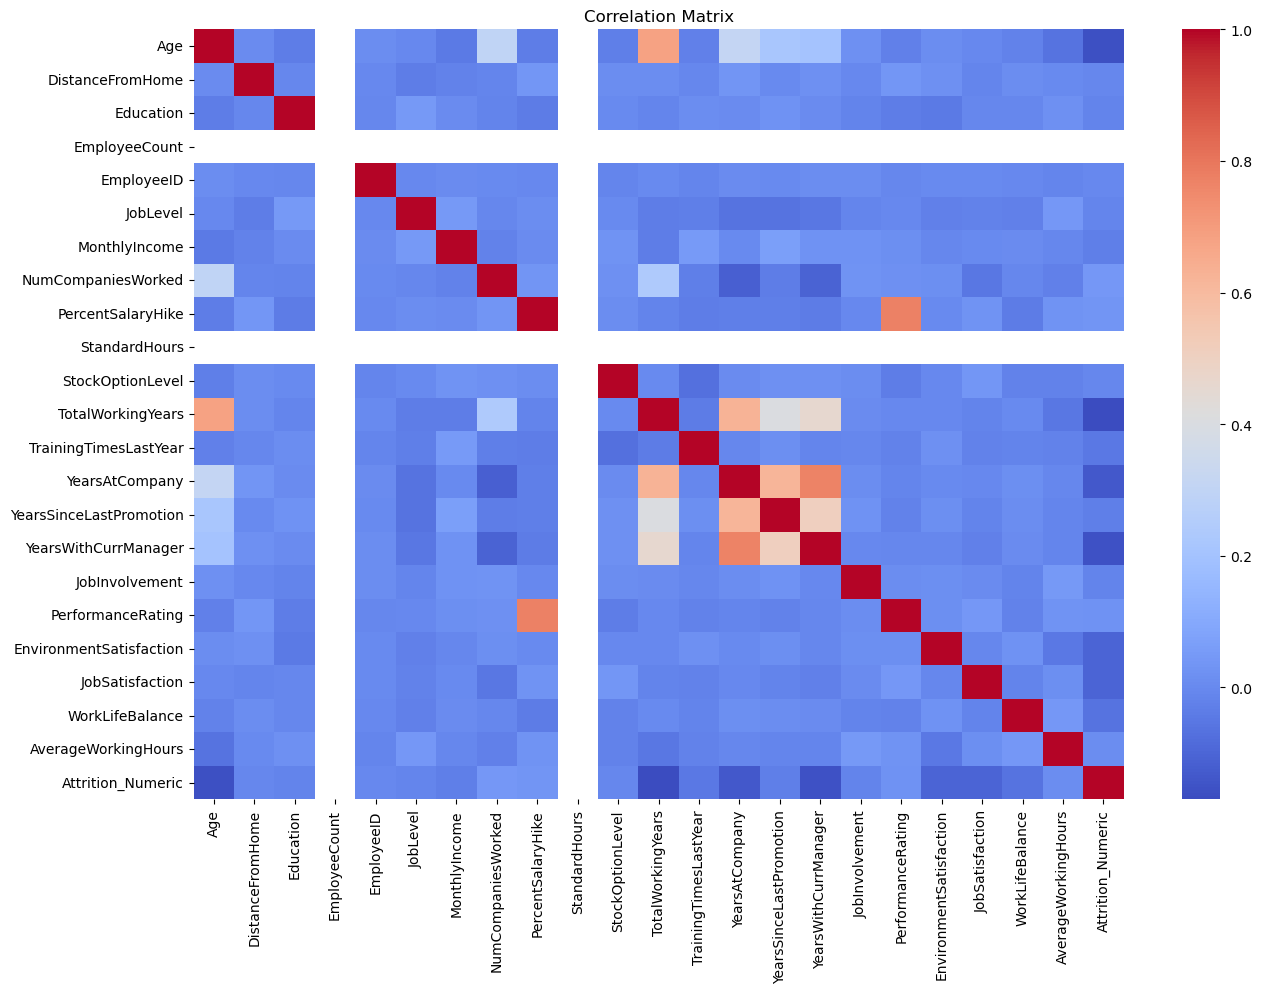

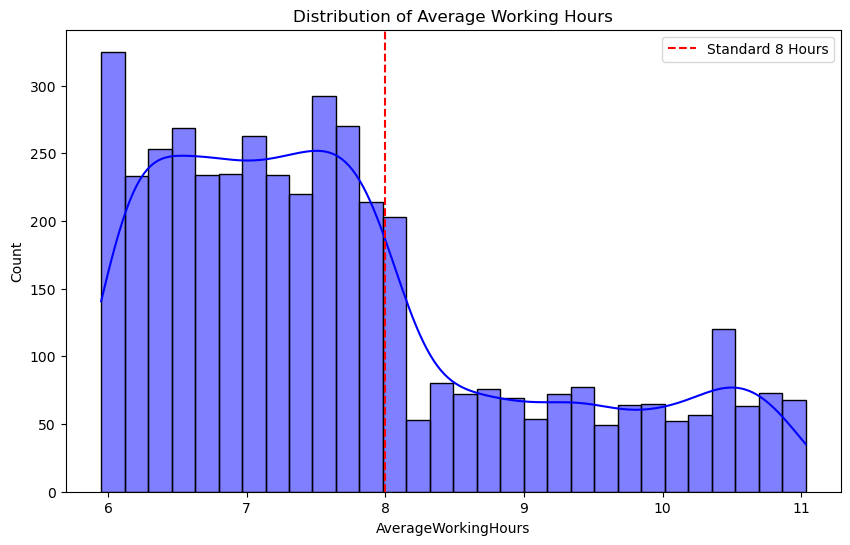

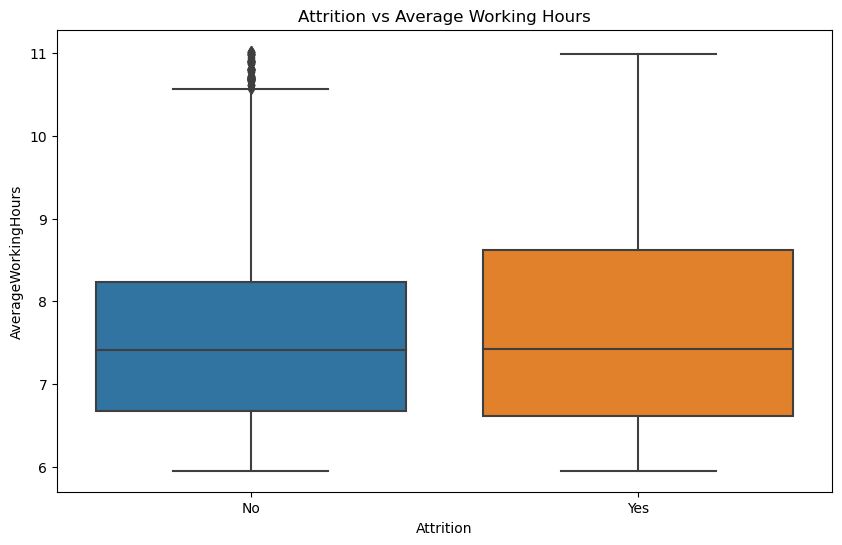

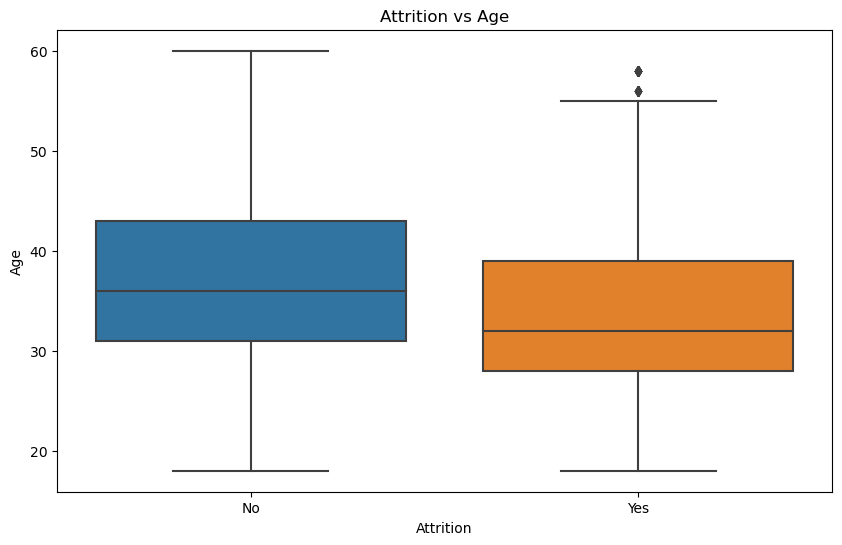

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
import os


if not os.path.exists('img'):
    os.makedirs('img')

# Encode Attrition for correlation analysis
main_df['Attrition_Numeric'] = main_df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# Select numerical columns for correlation
numeric_cols = main_df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = main_df[numeric_cols].corr()

# Plot Correlation Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('img/correlation_heatmap.png')

# Plot Distribution of Average Working Hours
plt.figure(figsize=(10, 6))
sns.histplot(main_df['AverageWorkingHours'], kde=True, bins=30, color='blue')
plt.axvline(x=8, color='red', linestyle='--', label='Standard 8 Hours')
plt.title('Distribution of Average Working Hours')
plt.legend()
plt.savefig('img/working_hours_dist.png') 

# Plot Attrition vs Working Hours
plt.figure(figsize=(10, 6))
sns.boxplot(x='Attrition', y='AverageWorkingHours', data=main_df)
plt.title('Attrition vs Average Working Hours')
plt.savefig('img/attrition_vs_hours.png') 

# Plot Attrition vs Age
plt.figure(figsize=(10, 6))
sns.boxplot(x='Attrition', y='Age', data=main_df)
plt.title('Attrition vs Age')
plt.savefig('img/attrition_vs_age.png')

print("Plots saved in 'img' folder.")

In [59]:
print("Correlation between Attrition and Working Hours:", main_df['Attrition_Numeric'].corr(main_df['AverageWorkingHours']))
print("Correlation between Attrition and Age:", main_df['Attrition_Numeric'].corr(main_df['Age']))
print("Correlation between Attrition and TotalWorkingYears:", main_df['Attrition_Numeric'].corr(main_df['TotalWorkingYears']))

Correlation between Attrition and Working Hours: 0.011482575694022805
Correlation between Attrition and Age: -0.15920500686577962
Correlation between Attrition and TotalWorkingYears: -0.17016240718829087


In [60]:
print("Mean Working Hours:", main_df['AverageWorkingHours'].mean())
print("Max Working Hours:", main_df['AverageWorkingHours'].max())
print("Min Working Hours:", main_df['AverageWorkingHours'].min())

Mean Working Hours: 7.700953237013053
Max Working Hours: 11.030960351376944
Min Working Hours: 5.950504160548056


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Création du dossier 'csv_out' s'il n'existe pas
if not os.path.exists('csv_out'):
    os.makedirs('csv_out')

# 1. Chargement des données
# (Assurez-vous que le dossier 'csv_in/' existe et contient les fichiers)
general_data = pd.read_csv('csv_in/general_data.csv')
employee_survey = pd.read_csv('csv_in/employee_survey_data.csv')
manager_survey = pd.read_csv('csv_in/manager_survey_data.csv')
in_time = pd.read_csv('csv_in/in_time.csv')
out_time = pd.read_csv('csv_in/out_time.csv')

# 2. Traitement des Valeurs Manquantes (Imputation)
# Numérique -> Médiane
for col in ['NumCompaniesWorked', 'TotalWorkingYears']:
    general_data[col] = general_data[col].fillna(general_data[col].median())

# Catégoriel -> Mode
for col in ['EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']:
    employee_survey[col] = employee_survey[col].fillna(employee_survey[col].mode()[0])

# 3. Ingénierie des Features Temporelles (Calcul des heures travaillées)
# Renommage pour la fusion
in_time.rename(columns={'Unnamed: 0': 'EmployeeID'}, inplace=True)
out_time.rename(columns={'Unnamed: 0': 'EmployeeID'}, inplace=True)

# Passage en Datetime et Indexation
in_time_idx = in_time.set_index('EmployeeID').apply(pd.to_datetime)
out_time_idx = out_time.set_index('EmployeeID').apply(pd.to_datetime)

# Calcul de la durée (Out - In)
working_duration = out_time_idx - in_time_idx

# Moyenne par employé (en heures)
avg_hours = working_duration.mean(axis=1).dt.total_seconds() / 3600
avg_hours_df = pd.DataFrame(avg_hours, columns=['AverageWorkingHours']).reset_index()

# 4. Fusion Finale
main_df = general_data.merge(manager_survey, on='EmployeeID', how='inner')
main_df = main_df.merge(employee_survey, on='EmployeeID', how='inner')
main_df = main_df.merge(avg_hours_df, on='EmployeeID', how='inner')

# Gestion des rares cas sans pointage (ex: Employee 1 si NaN) -> Imputation par la moyenne globale
if main_df['AverageWorkingHours'].isnull().sum() > 0:
    main_df['AverageWorkingHours'].fillna(main_df['AverageWorkingHours'].mean(), inplace=True)

# Encodage binaire de la cible pour l'analyse
main_df['Attrition_Numeric'] = main_df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# Sauvegarde dans le dossier csv_out
output_path = os.path.join('csv_out', 'final_dataset.csv')
main_df.to_csv(output_path, index=False)
print(f"Dataset final généré avec succès : {output_path}")
print(f"Dimensions : {main_df.shape}")

Dataset final généré avec succès : csv_out\final_dataset.csv
Dimensions : (4410, 31)
